In [5]:
import akshare as ak
import arrow
import datetime
import pandas as pd

df = ak.index_stock_cons_csindex(symbol="000300")
secs = df["成分券代码"]

合并收盘价和换手率，以便找出每日最低换手率

In [19]:
from typing import List

def prepare_data(secs: List[str], start: datetime.date, end: datetime.date):
    factors = []
    prices = []

    start_ = arrow.get(start).format("YYYYMMDD")
    end_ = arrow.get(end).format("YYYYMMDD")

    for sec in secs:
        bars = ak.stock_zh_a_hist(sec, adjust="qfq", start_date=start_, end_date=end_)
        bars["asset"] = [sec] * len(bars)
        prices.append(bars[["日期", "asset", "收盘"]])

        factors.append(bars[["日期", "asset", "换手率"]])

    # 处理因子表
    factor = pd.concat(factors)
    factor.rename(columns = {"换手率":"factor", "日期":"date"}, inplace=True)
    factor["date"] = pd.to_datetime(factor["date"], utc=True)
    factor.set_index(["date", "asset"], inplace=True)

    # 处理prices表格
    prices = pd.concat(prices).pivot(index="日期", columns="asset", values="收盘")

    # 价格表index类型转换： str -> date
    prices.index = pd.to_datetime(prices.index, utc=True)

    # 价格表index名字必须转换为'date'
    prices.rename_axis('date', inplace=True)


    return factor, prices
    
start = datetime.date(2023, 1, 3)
end = datetime.date(2023, 12, 31)
factor, prices = prepare_data(secs, start, end)

In [43]:
factor_data = get_clean_factor_and_forward_returns(factor, prices, bins=10, quantiles=None)
factor_data.groupby("factor_quantile").count()

Dropped 4.1% entries from factor data: 4.1% in forward returns computation and 0.0% in binning phase (set max_loss=0 to see potentially suppressed Exceptions).
max_loss is 35.0%, not exceeded: OK!


,1D,5D,10D,factor
factor_quantile,,,,
1,56367,56367,56367,56367
2,8205,8205,8205,8205
3,2404,2404,2404,2404
4,1011,1011,1011,1011
5,595,595,595,595
6,282,282,282,282
7,179,179,179,179
8,137,137,137,137
9,74,74,74,74


In [57]:
from alphalens.utils import get_clean_factor_and_forward_returns

factor_data = get_clean_factor_and_forward_returns(factor, prices, bins=None, quantiles=10)
factor_data.groupby("factor_quantile").mean()

Dropped 4.1% entries from factor data: 4.1% in forward returns computation and 0.0% in binning phase (set max_loss=0 to see potentially suppressed Exceptions).
max_loss is 35.0%, not exceeded: OK!


,1D,5D,10D,factor
factor_quantile,,,,
1,0.000282,0.001210,0.002412,0.134719
2,-0.000024,-0.000839,-0.000739,0.244580
3,-0.000355,-0.001357,-0.002082,0.331533
4,-0.000372,-0.001734,-0.002705,0.418632
5,-0.000157,-0.001909,-0.003790,0.514792
6,-0.000123,-0.002420,-0.005460,0.640887
7,-0.000648,-0.002914,-0.006666,0.811800
8,-0.000718,-0.004199,-0.009153,1.066287
9,-0.001183,-0.004689,-0.008731,1.544363


In [24]:
from alphalens.performance import mean_return_by_quantile

mean_return_by_q_daily, std_err = mean_return_by_quantile(
    factor_data, by_date=True)

mean_return_by_q_daily

1D        5D       10D
factor_quantile date                                                   
1               2023-01-03 00:00:00+00:00  0.006536 -0.019797 -0.027884
                2023-01-04 00:00:00+00:00 -0.007997 -0.017655 -0.031489
                2023-01-05 00:00:00+00:00 -0.005837 -0.012903 -0.032359
                2023-01-06 00:00:00+00:00 -0.005594 -0.006937 -0.031347
                2023-01-09 00:00:00+00:00 -0.007958 -0.010785 -0.028874
...                                             ...       ...       ...
10              2023-12-11 00:00:00+00:00 -0.012345 -0.018951 -0.030122
                2023-12-12 00:00:00+00:00  0.001937  0.001596 -0.021665
                2023-12-13 00:00:00+00:00 -0.004406 -0.014635 -0.025475
                2023-12-14 00:00:00+00:00  0.001244 -0.004513 -0.013856
                2023-12-15 00:00:00+00:00 -0.001489  0.003975  0.016065

[2320 rows x 3 columns]

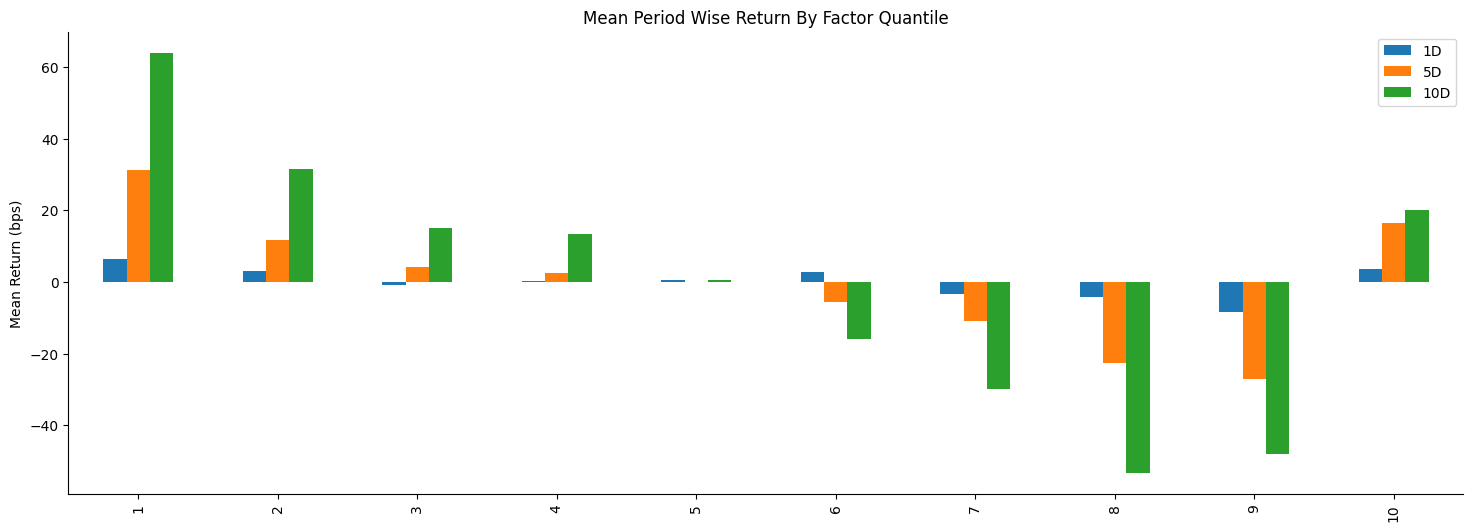

In [25]:
import seaborn as sns
from alphalens.plotting import plot_quantile_returns_bar

mean_return_by_q_daily, std_err = mean_return_by_quantile(
    factor_data, by_date=False)
plot_quantile_returns_bar(mean_return_by_q_daily)
sns.despine()

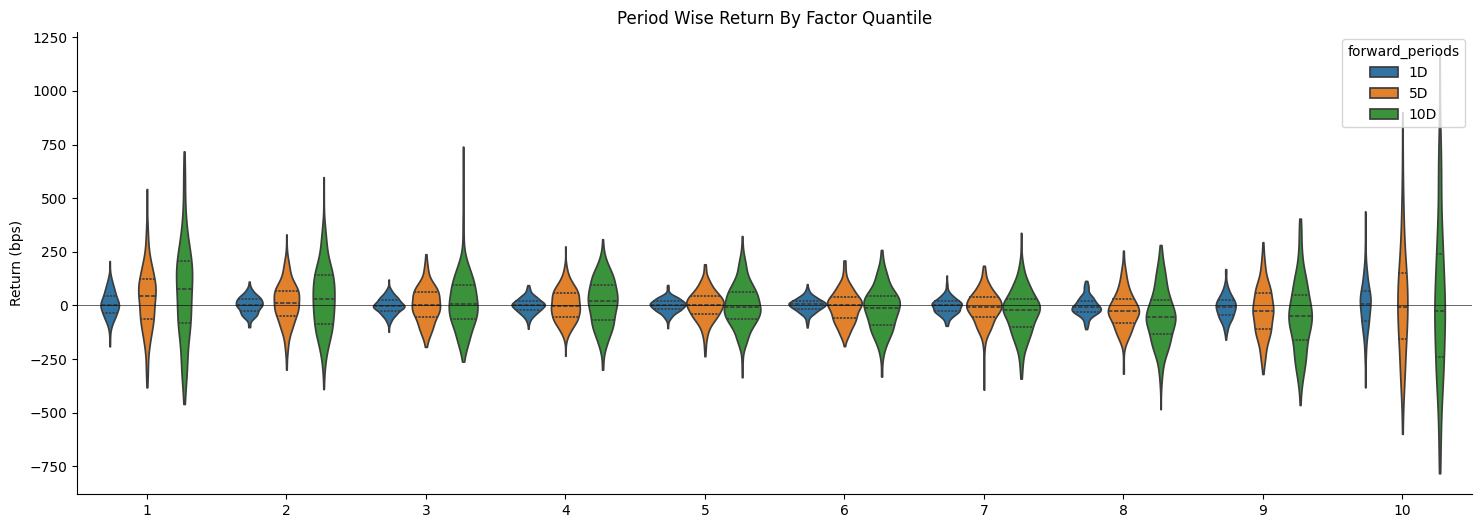

In [26]:
from alphalens.plotting import plot_quantile_returns_violin

mean_return_by_q_daily, std_err = mean_return_by_quantile(
    factor_data, by_date=True)
plot_quantile_returns_violin(mean_return_by_q_daily)
sns.despine()

[<Axes: title={'center': 'Top Minus Bottom Quantile Mean Return (1D Period Forward Return)'}, ylabel='Difference In Quantile Mean Return (bps)'>,
 <Axes: title={'center': 'Top Minus Bottom Quantile Mean Return (5D Period Forward Return)'}, ylabel='Difference In Quantile Mean Return (bps)'>,
 <Axes: title={'center': 'Top Minus Bottom Quantile Mean Return (10D Period Forward Return)'}, ylabel='Difference In Quantile Mean Return (bps)'>]

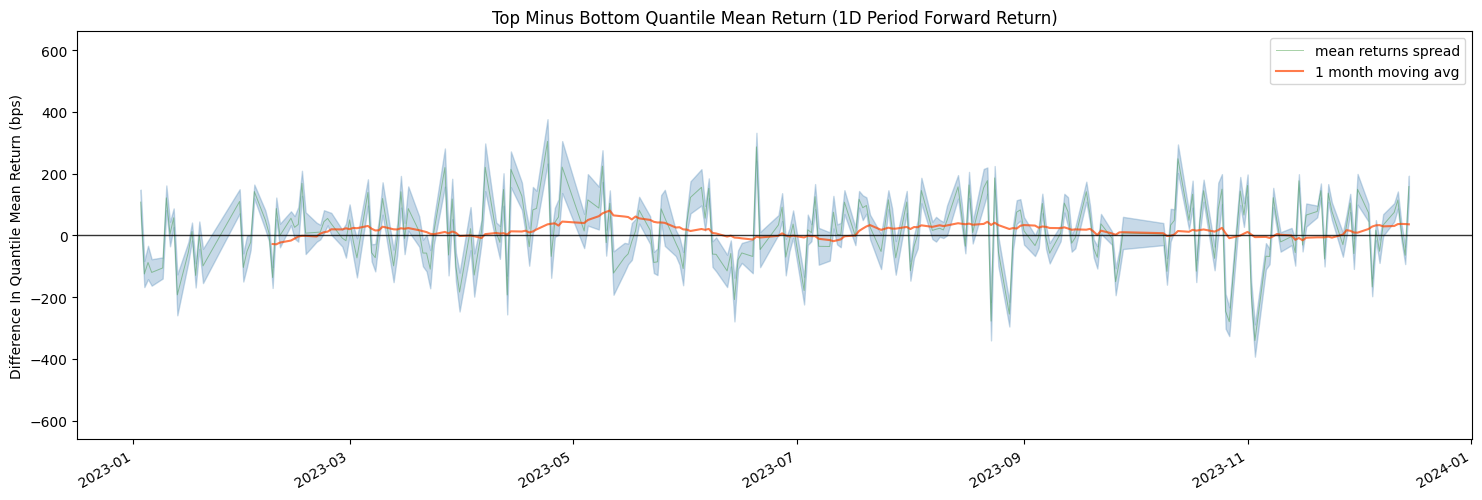

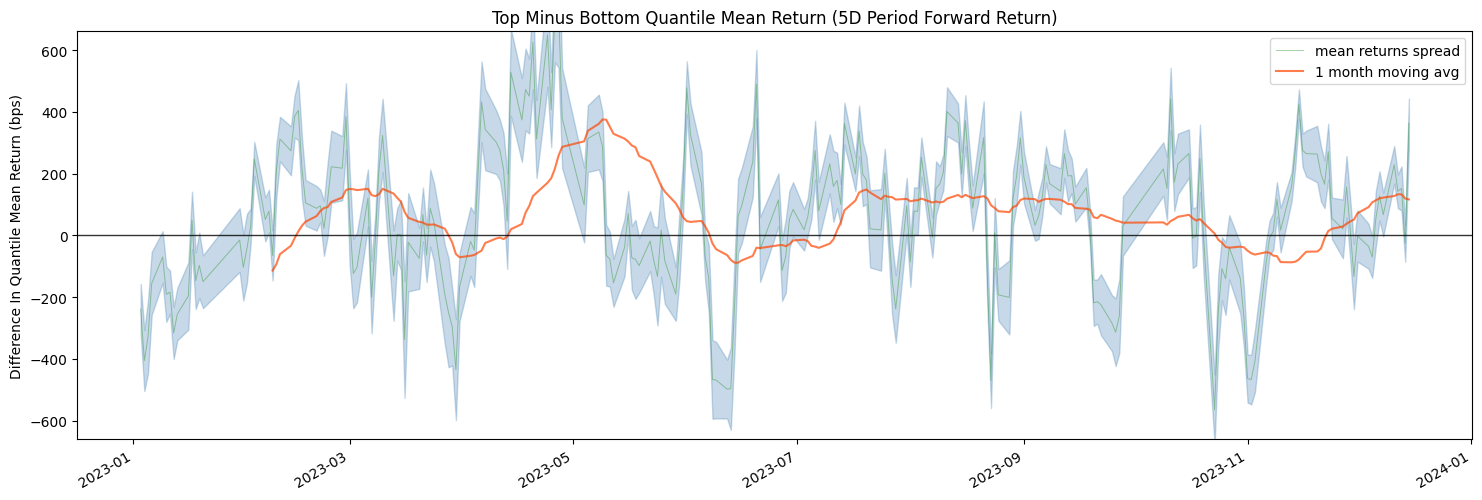

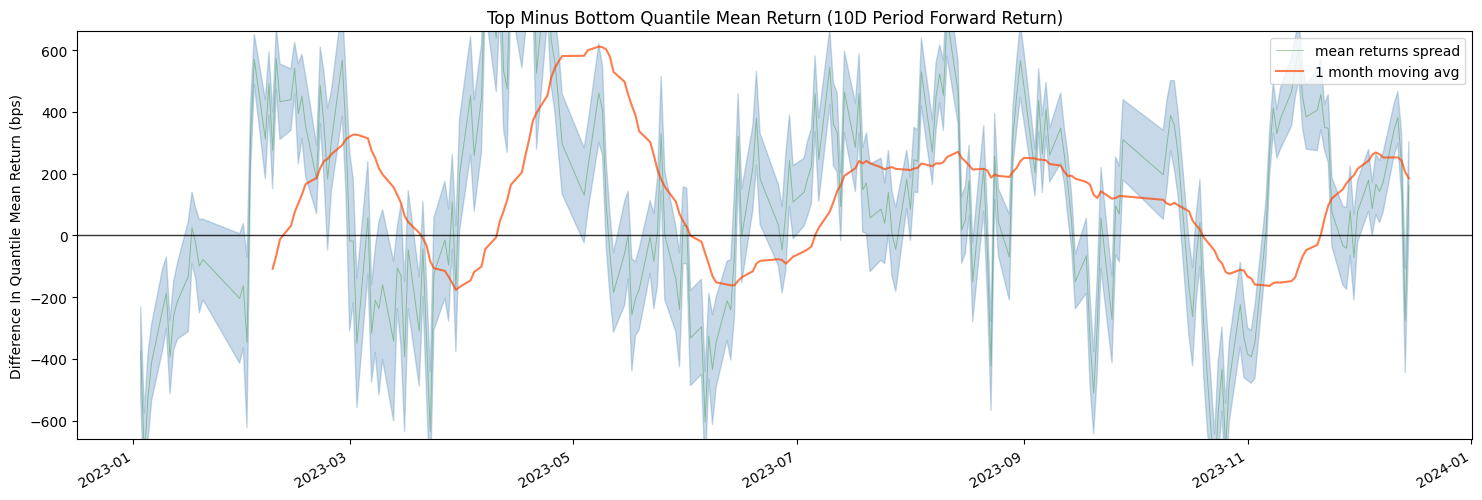

In [27]:
from alphalens.performance import compute_mean_returns_spread
from alphalens.plotting import plot_mean_quantile_returns_spread_time_series

qrs, ses = compute_mean_returns_spread(mean_return_by_q_daily,upper_quant=1, lower_quant=9,std_err=std_err)

plot_mean_quantile_returns_spread_time_series(qrs, ses)


<Axes: title={'center': 'Cumulative Return by Quantile\n                    (1D Period Forward Return)'}, ylabel='Log Cumulative Returns'>

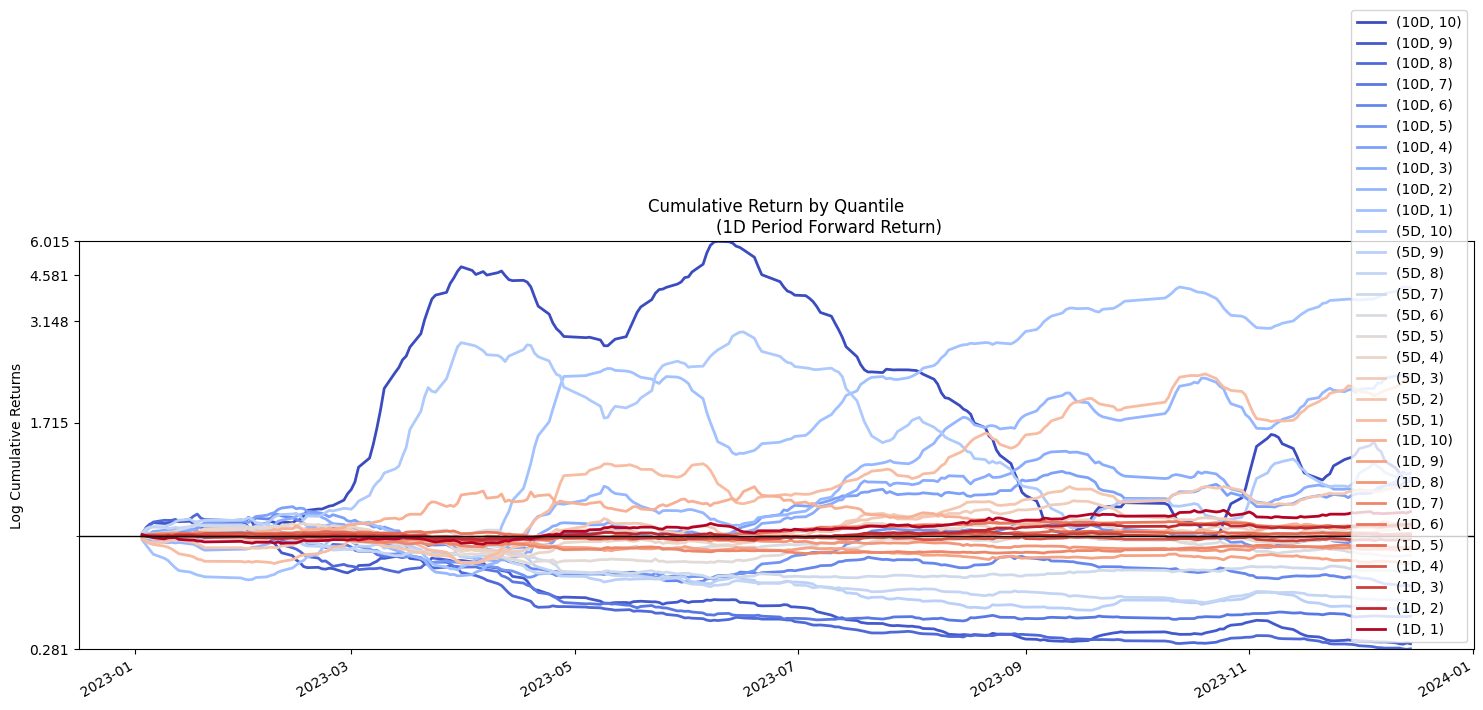

In [28]:
from alphalens.plotting import plot_cumulative_returns_by_quantile

mean_return_by_q_daily, std_err = mean_return_by_quantile(
    factor_data, by_date=True)
plot_cumulative_returns_by_quantile(mean_return_by_q_daily, period='1D')

## 计算alpha beta时的问题

In [45]:
from alphalens.performance import factor_alpha_beta

factor_data = get_clean_factor_and_forward_returns(factor, prices, bins=None, quantiles=10)
ab = factor_alpha_beta(factor_data)
ab

,1D,5D,10D
Ann. alpha,0.027455,0.058458,0.022515
beta,0.353804,0.207438,0.173700


In [51]:
from alphalens.performance import factor_alpha_beta

factor_data = get_clean_factor_and_forward_returns(factor, prices, bins=None, quantiles=10)

factor_data.factor = max(factor_data.factor) - factor_data.factor
ab = factor_alpha_beta(factor_data, demeaned=False)
ab

Dropped 4.1% entries from factor data: 4.1% in forward returns computation and 0.0% in binning phase (set max_loss=0 to see potentially suppressed Exceptions).
max_loss is 35.0%, not exceeded: OK!


,1D,5D,10D
Ann. alpha,-0.000295,-0.000553,-0.000196
beta,0.996347,0.997623,0.997874


## 演示alphalens中factor_weights的算法

In [53]:
tm = datetime.datetime(2023, 1, 1, 0)
df = pd.DataFrame([
    (tm, "A", 0.01, 1),
    (tm, "B", 0.02, 2),
    (tm, "C", 0.03, 3),
    (tm, "D", 0.04, 4)
], columns=["date", "asset", "1D", "factor"])

sample_factor_data = df.set_index(["date", "asset"])
sample_factor_data


1D  factor
date       asset              
2023-01-01 A      0.01       1
           B      0.02       2
           C      0.03       3
           D      0.04       4

In [54]:
from alphalens.performance import factor_weights
factor_weights(sample_factor_data, demeaned=False)

date        asset
2023-01-01  A        0.1
            B        0.2
            C        0.3
            D        0.4
Name: factor, dtype: float64

现在，我们修改一下factor，然后仅以单边做多的方式来计算其alpha和beta:

In [61]:
from alphalens.utils import get_clean_factor_and_forward_returns

factor_data = get_clean_factor_and_forward_returns(factor, prices, bins=None, quantiles=10)

factor_data.factor = 1 / factor_data.factor

factor_alpha_beta(factor_data,demeaned=False)

Dropped 4.1% entries from factor data: 4.1% in forward returns computation and 0.0% in binning phase (set max_loss=0 to see potentially suppressed Exceptions).
max_loss is 35.0%, not exceeded: OK!


,1D,5D,10D
Ann. alpha,0.044817,0.043466,0.048470
beta,0.816272,0.815888,0.773899


In [64]:
start = datetime.date(2023, 1, 3)
end = datetime.date(2023, 12, 31)
factor, prices = prepare_data(secs, start, end)

factor.factor = 1 / factor.factor

factor_data = get_clean_factor_and_forward_returns(factor, prices, bins=None, quantiles=10)

mean_return_by_q_daily, std_err = mean_return_by_quantile(
    factor_data, by_date=False)
plot_quantile_returns_bar(mean_return_by_q_daily)
sns.despine()

,,factor
date,asset,
2023-01-03 00:00:00+00:00,000001,0.884956
2023-01-04 00:00:00+00:00,000001,0.884956
2023-01-05 00:00:00+00:00,000001,1.162791
2023-01-06 00:00:00+00:00,000001,1.612903
2023-01-09 00:00:00+00:00,000001,1.818182
...,...,...
2023-12-25 00:00:00+00:00,688981,1.111111
2023-12-26 00:00:00+00:00,688981,1.369863
2023-12-27 00:00:00+00:00,688981,1.298701


In [97]:
import re
def get_img_url(text: str):
    groups = re.search(r"\!\[.*\]\((.*)\)", text)
    if groups is None:
        groups = re.search(r"<\s*img\s+src=[\'\"](.+)\s*>", text)
        if groups is None:
            return None, text
        
        url = groups.group(1)
        return url, re.sub(r"<\s*img\s+src=[\'\"].+\s*[\'\"]>", "", text)

    return groups.group(1), re.sub(r"\!\[.*\]\(.*\)", "", text)

In [112]:
import os
import glob
import re

articles = glob.glob("/apps/zillionare/docs/articles/**/*.md", recursive=True)
for file in articles:
    matched = re.match(r".*/articles/(.+)/.*\.md", file)
    print(matched.group(1))

investment/量化库
investment/量化库/数据持久化
investment/量化杂谈
investment/量化杂谈
investment/策略研究
investment/策略研究
investment/策略研究
investment/策略研究
investment/策略研究
investment/策略研究
products
products
products
products
python/visualize
python/visualize
python/visualize
python/visualize
python/visualize
python/best-practice-python
python/best-practice-python
python/best-practice-python
python/best-practice-python
python/best-practice-python
python/best-practice-python
python/best-practice-python
python/best-practice-python
python/best-practice-python
python/best-practice-python
python/best-practice-python
coursea/qmt
coursea/qmt
coursea/qmt
coursea/24lectures
coursea/24lectures
coursea/24lectures
coursea/24lectures
coursea/24lectures
